<a href="https://colab.research.google.com/github/angusjf/angusjf.github.io/blob/master/KUL_CV_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer vision Final project

In [0]:
#@title ## Configuration { run: "auto" }

VOC_ROOT_FOLDER = "/content/VOCdevkit/VOC2009/" #@param {type: "string"}

Imports

In [2]:
%pip install --upgrade wandb -q
!wandb login 3cd8a6fff84595b3101d186ceece689768431faf

     |████████████████████████████████| 1.4MB 3.5MB/s 
     |████████████████████████████████| 112kB 63.0MB/s 
     |████████████████████████████████| 102kB 14.7MB/s 
     |████████████████████████████████| 102kB 14.2MB/s 
     |████████████████████████████████| 460kB 62.6MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
import glob
import cv2
import os
import xml.dom.minidom as xmlparser
import numpy as np
from lxml import etree
from enum import IntEnum
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from skimage import io
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
from albumentations import (
    Compose, OneOf, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, Blur
)
import albumentations.augmentations.transforms as transforms

import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)
import wandb
from wandb.keras import WandbCallback
from sklearn.utils import shuffle
from google.colab import widgets
import random

Fetch data

In [9]:
!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
!tar -xf VOCtrainval_11-May-2009.tar --totals

--2020-04-29 13:14:55--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... Read error (Connection reset by peer) in headers.
Retrying.

--2020-04-29 13:16:18--  (try: 2)  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935534080 (892M) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2009.tar’

VOCtrainval_11-May- 100%[===================>] 892.19M  10.3MB/s    in 85s     

2020-04-29 13:18:11 (10.5 MB/s) - ‘VOCtrainval_11-May-2009.tar’ saved [935534080/935534080]

Total bytes read: 935536640 (893MiB, 259MiB/s)


Use GPU

Utils for segmentation

In [0]:
# Based on https://github.com/tensorflow/models/blob/master/research/deeplab/utils/get_dataset_colormap.py
def bit_get(val, idx):
  return (val >> idx) & 1

# accepts HWC format
def label_to_color_image(label):
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label. Got {}'.format(label.shape))

  if np.max(label) >= 512:
    raise ValueError(
        'label value too large: {} >= {}.'.format(
            np.max(label), 512))

  colormap = create_pascal_label_colormap()
  return colormap[label]

def create_pascal_label_colormap():

  colormap = np.zeros((512, 3), dtype=int)
  ind = np.arange(512, dtype=int)

  for shift in reversed(list(range(8))):
    for channel in range(3):
      colormap[:, channel] |= bit_get(ind, channel) << shift
    ind >>= 3

  return colormap


Preparing dataset

In [0]:
class VOCDataset(Sequence):
    CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
            'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
            'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
            'tvmonitor']

    def __init__(self, dataset_type, split, train_shuffle=False, *args, **kwargs):
        super().__init__()

        self._whole_dataset = dataset_type(*args, **kwargs)
        self._subsets = dict()
        
        slices = np.round(np.cumsum([0] + split) * len(self._whole_dataset._ids)).astype(int)
        print(slices)
        for i, name in enumerate(("train", "val", "tst")):
            shuffle = (name == "train" and train_shuffle)

            self._subsets[name] = dataset_type(*args, **kwargs, shuffle=shuffle, subset_slice=slice(slices[i], slices[i + 1]))

    def tr_set(self):
        return self._subsets.get("train")

    def val_set(self):
        return self._subsets.get("val")

    def tst_set(self):
        return self._subsets.get("tst")

    def __len__(self):
        return len(self._whole_dataset)

    def __getitem__(self, idx):
        return self._whole_dataset[idx]

LabelClass = IntEnum("LabelClass", {label: i + 1 for i, label in enumerate(VOCDataset.CLASSES)})

DAtaset for classification (one-hot encoding)

In [0]:
class VOCClassificationSubset(Sequence):
    def __init__(self, dataset_root_dir, target_cls, batch_size=1, subset_slice=slice(0, None), transform=None, shuffle=False):
        super().__init__()

        self._target_cls = target_cls.name
        self._shuffle = shuffle
        self._batch_size = batch_size
        self._dir = dataset_root_dir
        self._transform = transform
        with open(os.path.join(self._dir, "ImageSets/Main/trainval.txt")) as f:
            self._ids = sorted(filter(None, (map(lambda x: x.split(" ")[0], f.read().split("\n")))))
        # take subset
        self._ids = self._ids[subset_slice]
        self._labels = list()
        self._sorted_data = {cls_str: list() for cls_str in VOCDataset.CLASSES}

        for single_id in self._ids:
            tree = etree.parse(os.path.join(self._dir, "Annotations", "{}.xml".format(single_id)))
            #labels = set(tree.xpath("//object/name/text()")) & set(VOCDataset.CLASSES)
            labels = list(tree.xpath("//object/name/text()"))

            self._labels.append(list(map(lambda x: LabelClass[x], labels)))
            for single_label in labels:
                self._sorted_data[single_label].append(
                    (single_id, list(map(lambda x: LabelClass[x], labels)))
                )
        self.a = list()


    def on_epoch_end(self):
        if self._shuffle:
            self._ids, self._labels = shuffle(self._ids, self._labels)

    def set_transform(self, transform):
        self._transform = transform

    def __len__(self):
        return int(len(self._ids) / self._batch_size)

    def __getitem__(self, idx):
        data = [self._get_single_item(x) for x in range(idx * self._batch_size, (idx + 1) * self._batch_size)]
        images, labels = zip(*data)
        return np.array(images), np.array(labels)

    def _get_single_item(self, idx):
        if random.randint(0, 1):
            classes = list(set(VOCDataset.CLASSES) - {self._target_cls, })
            cls_name = classes[random.randint(0, len(classes) - 1)]
        else:
            cls_name = self._target_cls

        cls_data = self._sorted_data[cls_name]
        item_id, labels = cls_data[random.randint(0, len(cls_data) - 1)]
        labels = [label.value - 1 for label in labels]
        self.a.append(cls_name)

        # TODO uncomment?
        #item_id = self._ids[idx]
        #labels = [label.value - 1 for label in self._labels[idx]]

        # one-hot encode
        # TODO uncomment?
        #encoded_labels = np.zeros((len(VOCDataset.CLASSES), ), dtype=float)
        #encoded_labels[labels] = 1.
        encoded_labels = float((LabelClass["car"].value - 1) in labels)

        image = io.imread(os.path.join(self._dir, "JPEGImages", "{}.jpg".format(item_id)))
        if self._transform:
            image = self._transform(image=image).get("image")

        return image, encoded_labels    

[   0 4232 5643 7054]
264 88 88
440
(16, 500, 500, 3) (16,)
1.0
LabelClass.aeroplane


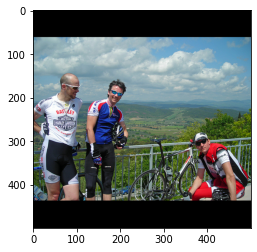

In [13]:
# Example for classification dataset
augmentation = Compose([
    transforms.PadIfNeeded(
        min_height=500, 
        min_width=500, 
        border_mode=cv2.BORDER_CONSTANT, 
        value=0
    )
])

dataset = VOCDataset(
    VOCClassificationSubset, 
    split=[0.6, 0.2, 0.2], 
    dataset_root_dir=VOC_ROOT_FOLDER, 
    batch_size=16, 
    transform=augmentation,
    target_cls=LabelClass.car
)
tr = dataset.tr_set()
val = dataset.val_set()
test = dataset.tst_set()
print(len(tr), len(val), len(test))
print(len(dataset))
# use validation for example
dataset = val


# getting sample
images, labels = dataset[1]
print(images.shape, labels.shape)
image, label = images[0], labels[0]

# NHWC format
print(label)

for i in np.squeeze(np.nonzero(label), axis=0):
    print(LabelClass(i + 1))

plt.imshow(image)
plt.show()

Dataset for segmentation

In [0]:
class VOCSegmentationDataset(Sequence):
    def __init__(self, dataset_root_dir, batch_size=1, subset_slice=slice(0, None), transform=None, input_transform=None, shuffle=False):
        # warning: shuffle is unimplemented, i added it to fix an error :) TODO
        super().__init__()

        self._batch_size = batch_size
        self._dir = dataset_root_dir
        self._transform = transform
        self._input_transform = input_transform
        with open(os.path.join(self._dir, "ImageSets/Segmentation/trainval.txt")) as f:
            self._ids = tuple(filter(None, f.read().split("\n")))
        # take subset
        self._ids = self._ids[subset_slice]

    def __len__(self):
        return int(len(self._ids) / self._batch_size)

    def __getitem__(self, idx):
        data = [self._get_single_item(x) for x in range(idx * self._batch_size, (idx + 1) * self._batch_size)]
        images, masks, ROIs = zip(*data)
        return np.array(images), np.array(masks), np.array(ROIs)

    def _get_single_item(self, idx):
        item_id = self._ids[idx]

        # NHWC format
        image = io.imread(os.path.join(self._dir, "JPEGImages", "{}.jpg".format(item_id)))
        mask = io.imread(os.path.join(self._dir, "SegmentationClass", "{}.png".format(item_id)))[..., :3]
        voc_colormap = create_pascal_label_colormap()

        # convert mask to a single channel
        r_mask, g_mask, b_mask = np.transpose(mask, axes=(2, 0, 1))
        class_mask = np.zeros(mask.shape[:2] + (len(VOCDataset.CLASSES) + 1, ), dtype=np.uint8)

        for i in range(0, len(VOCDataset.CLASSES) + 1):
            color = voc_colormap[i]
            class_mask[..., i] = ((r_mask == color[0]) * (g_mask == color[1]) * (b_mask == color[2]))

        if self._transform:
            transformed = self._transform(image=image, class_mask=class_mask)
            
            image= transformed.get("image")
            class_mask = transformed.get("class_mask")
        
        if self._input_transform:
            image = self._input_transform(image=image).get("image")
        
        color = voc_colormap[255]
        ROI_mask = ((r_mask == color[0]) * (g_mask == color[1]) * (b_mask == color[2]))

        return image, class_mask, ROI_mask

In [15]:
# Example for segmentation dataset
augmentation = Compose([
        transforms.ToFloat(),
        transforms.PadIfNeeded(
            min_height=500, 
            min_width=500, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0
        ),

        transforms.Resize(
            width=150,
            height=150
        ),
    ],
    additional_targets={
        'class_mask': 'image',
    }
)

dataset = VOCDataset(
    VOCSegmentationDataset, 
    split=[0.6, 0.2, 0.2], 
    dataset_root_dir=VOC_ROOT_FOLDER, 
    batch_size=1, 
    transform=augmentation
)
tr = dataset.tr_set()
val = dataset.val_set()
test = dataset.tst_set()
print(len(tr), len(val), len(test))
print(len(dataset))
# use validation for example
dataset = val

# getting sample (mask and image are stored in dict)
imgs, masks, ROImasks = dataset[1]
print(imgs.shape)
img = imgs[0]
mask = masks[0]
ROImask = ROImasks[0]

plt.imshow(img)
plt.show()

print(mask.shape)
mask = np.argmax(mask, axis=2)
plt.imshow(mask)
plt.show()

# reconstruction from single channel mask (value is pixel is equal to its class)
print(mask.shape)
plt.imshow(label_to_color_image(mask))
plt.show()

[   0  899 1199 1499]


TypeError: ignored

## Task 1: Classificaion

Check https://app.wandb.ai/sonypony/cv03_classification?workspace=user-sonypony


Used some tips for multi-label multi-class nns I found here: https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks/

### Plotting functions

In [0]:
def plot_accuracy(hist):  
  # Plot training & validation accuracy values
  plt.plot(hist['accuracy'])
  plt.plot(hist['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.ylim(ymin=0, ymax=1)
  plt.show()

In [0]:
def plot_loss(hist):
  # Plot training & validation loss values
  plt.plot(hist['loss'])
  plt.plot(hist['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.ylim(ymin=0)
  plt.show()

In [0]:
def plot_multilabel_predictions(predictions, index):
  labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
              'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
              'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
              'tvmonitor']
  img = dataset.val_set()[1][0][index]
  
  plt.subplot(2,1,1)
  plt.imshow(img)

  print("most likley class:")
  print(" -> " + labels[np.argmax(predictions[index])])

  print("predictions:")
  print(predictions[index])

  print("ground truth:")
  actual = dataset.val_set()[1][1][index]
  print(actual)

  plt.subplot(2,1,2)
  y_pos = np.arange(len(labels))
  _ = plt.bar(y_pos, actual, width=0.2)
  _ = plt.bar(y_pos, predictions[index])
  _ = plt.xticks(y_pos, labels, rotation=90)
  _ = plt.ylim(ymin=0, ymax=1)

In [0]:
def plot_binary_predictions(predictions, index):
  labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
              'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
              'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
              'tvmonitor']
  img = dataset.val_set()[1][0][index]
  
  plt.subplot(2,1,1)
  plt.imshow(img)

  print("most likley class:")
  print(" -> " + labels[np.argmax(predictions[index])])

  print("predictions:")
  print(predictions[index])

  print("ground truth:")
  actual = dataset.val_set()[1][1][index]
  print(actual)

  plt.subplot(2,1,2)
  y_pos = np.arange(1)
  
  _ = plt.bar(y_pos, np.asarray([actual]), width=0.2)
  _ = plt.bar(y_pos, predictions[index])
  # _ = plt.xticks(y_pos, labels, rotation=90)
  _ = plt.ylim(ymin=0, ymax=1)

### Network 1 - Train From Scratch

In [0]:
config_settings = dict(
    batch_size = 64,
    input_size = 224,
    lr = 1e-4,
    epoch_count = 25
)

#### Dataset & Preprocessing

In [21]:
augmentation = Compose([
    transforms.PadIfNeeded(
        min_height=500, 
        min_width=500, 
        border_mode=cv2.BORDER_CONSTANT, 
        value=0
    ),

    transforms.Resize(
        width=config_settings.get("input_size"),
        height=config_settings.get("input_size")
    ),

    transforms.HorizontalFlip(),
    transforms.ShiftScaleRotate(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    transforms.ToFloat(max_value=255)
])

val_transform = Compose([
    transforms.Resize(
        width=config_settings.get("input_size"),
        height=config_settings.get("input_size")
    ),
    transforms.ToFloat(max_value=255)
])


dataset = VOCDataset(
    VOCClassificationSubset, 
    split=[0.8, 0.1, 0.1],
    train_shuffle=True, 
    dataset_root_dir=VOC_ROOT_FOLDER, 
    batch_size=config_settings.get("batch_size"), 
    transform=augmentation,
    target_cls=LabelClass.car
)

tr_data = dataset.tr_set()
val_data = dataset.val_set()
val_data.set_transform(val_transform)

[   0 5643 6349 7054]


#### Binary Model

In [22]:
from keras import layers, models, optimizers

def get_model():
    input_image = layers.Input(shape = (config_settings.get("input_size"),config_settings.get("input_size"),3))
    x = layers.Conv2D(32, (3, 3), padding = 'same',activation='relu')(input_image)
    x = layers.Conv2D(32, (3, 3), padding = 'same',activation='relu')(x)
    x = layers.Conv2D(32, (3, 3), padding = 'same',activation='relu')(x)
    x = layers.MaxPooling2D(pool_size = (2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), padding = 'same',activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), padding = 'same',activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), padding = 'same',activation='relu')(x)
    x = layers.MaxPooling2D(pool_size = (2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding = 'same',activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), padding = 'same',activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), padding = 'same',activation='relu')(x)
    x = layers.MaxPooling2D(pool_size = (2, 2))(x)
    
    x = layers.Conv2D(256, (3, 3), padding = 'same',activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding = 'same',activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding = 'same',activation='relu')(x)
    x = layers.MaxPooling2D(pool_size = (2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512,activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512,activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    output = layers.Dense(1, name = 'dense1')(x)
    output = layers.Activation('sigmoid',name='output_layer')(output)
    
    model = models.Model(input_image,output)
  
    return model

model = get_model()

Using TensorFlow backend.


In [23]:
wandb.init(project="cv03_classification", config=config_settings)
model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=config_settings.get("lr")),
  loss="binary_crossentropy",
  metrics=["accuracy"]
)

history = model.fit(
    tr_data, 
    steps_per_epoch=len(tr_data), 
    validation_data=val_data,
    validation_steps=len(val_data),
    epochs=config_settings.get("epoch_count"),
    callbacks=[WandbCallback()]
)

model.save(os.path.join(wandb.run.dir, "model.h5"))

Epoch 1/25
88/88 [==============================] - 52s 596ms/step - loss: 0.6741 - accuracy: 0.5891 - val_loss: 0.6954 - val_accuracy: 0.6179


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/25
88/88 [==============================] - 50s 571ms/step - loss: 0.6116 - accuracy: 0.6768 - val_loss: 0.6520 - val_accuracy: 0.6648
Epoch 3/25
88/88 [==============================] - 50s 567ms/step - loss: 0.5996 - accuracy: 0.6852 - val_loss: 0.6853 - val_accuracy: 0.6023
Epoch 4/25
88/88 [==============================] - 50s 564ms/step - loss: 0.5929 - accuracy: 0.6870 - val_loss: 0.6057 - val_accuracy: 0.6619
Epoch 5/25
88/88 [==============================] - 50s 564ms/step - loss: 0.5648 - accuracy: 0.7152 - val_loss: 0.6754 - val_accuracy: 0.6861
Epoch 6/25
88/88 [==============================] - 49s 562ms/step - loss: 0.5779 - accuracy: 0.7008 - val_loss: 0.5418 - val_accuracy: 0.6605
Epoch 7/25
88/88 [==============================] - 49s 562ms/step - loss: 0.5588 - accuracy: 0.7209 - val_loss: 0.6150 - val_accuracy: 0.6591
Epoch 8/25
88/88 [==============================] - 50s 567ms/step - loss: 0.5531 - accuracy: 0.7234 - val_loss: 0.6664 - val_accuracy: 0.6136

#### Multi-Label Multi-Class Model

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(20, activation='sigmoid')
])

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),#lr=1e-6
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [0]:
history = model.fit(
    training,
    steps_per_epoch=len(training),
    validation_data=dataset.val_set(),
    validation_steps=len(validation),
    epochs=24
)

#### Model Evaluation & Testing

In [0]:
tst = dataset.tst_set()

for index in range(1, 15):
    img_batch, label_batch = tst[index]
    print(img_batch.shape, label_batch.shape)
    predictions = model.predict(img_batch)
    
    img = img_batch[0]

    print("Pred:", predictions[0])

    label = label_batch[0]
    print("GT:", label)
    #for i in np.squeeze(np.nonzero(label), axis=0):
    #    print(LabelClass(i + 1))

    plt.imshow(img)
    plt.show()

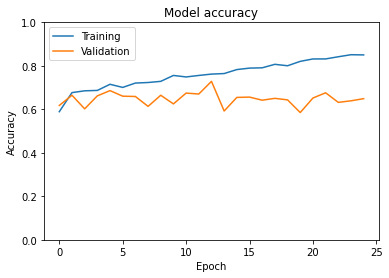

In [27]:
plot_accuracy(history.history)

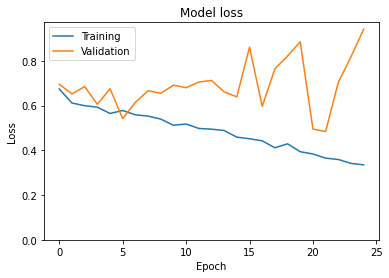

In [28]:
plot_loss(history.history)

In [0]:
predictions = model.predict(dataset.val_set())

most likley class:
 -> aeroplane
predictions:
[0.777246]
ground truth:
0.0


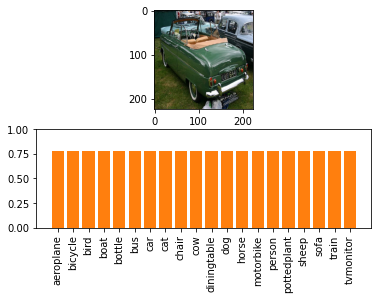

In [52]:
# only relevent for multilabel
# plot_multilabel_predictions(predictions, 10)

### Network 2 - Transfer Weights

#### The Model

In [0]:
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3) #to be more consistent with resnet?
)

# freeze the layers!
n_frozen_layers = 175 # max = 175
for layer in base_model.layers[:n_frozen_layers]:
    layer.trainable = False

In [0]:
# make wrapping model
flatten = tf.keras.layers.Flatten()(base_model.output)
dense = tf.keras.layers.Dense(1024, activation='relu')(flatten)
predictions = tf.keras.layers.Dense(2, activation='softmax')(dense)
model = tf.keras.models.Model(base_model.input, outputs=predictions)

In [0]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9),
    metrics=["accuracy"]
)

In [94]:
history = model.fit(
    tr_data,
    steps_per_epoch=len(tr_data),
    validation_data=val_data,
    validation_steps=len(val_data),
    epochs=24
)

Epoch 1/24


ValueError: ignored

#### Model Evaluation & Testing

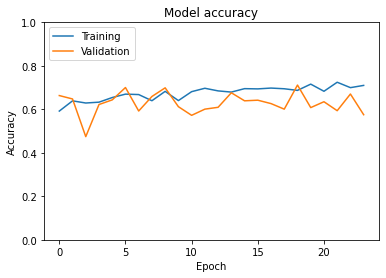

In [86]:
plot_accuracy(history.history)

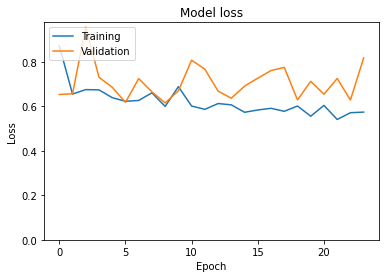

In [87]:
plot_loss(history.history)

In [0]:
predictions = model.predict(dataset.val_set())

most likley class:


NotImplementedError: ignored

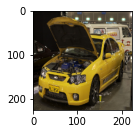

In [88]:
plot_multilabel_predictions(predictions, 9)